In [3]:
import pandas as pd
import numpy as np

print("Loading data...")
file_path = 'Data/stock_data.csv'

try:

    df = pd.read_csv(file_path, header=0, skiprows=[1, 2])
    df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    print("Data loaded successfully!")

    df['Daily_Return'] = df['Close'].pct_change()
    df['Volume_MA_7'] = df['Volume'].rolling(window=7).mean()
    
    print("\nDaily Features Created (First 5 rows):")
    print(df[['Close', 'Daily_Return', 'Volume_MA_7']].head())

    monthly_df = df.resample('ME').agg({
        'Daily_Return': 'std',  
        'Volume': 'mean',      
        'Close': 'mean'         
    })

    monthly_df.rename(columns={
        'Daily_Return': 'Volatility_Current',
        'Volume': 'Volume_Mean',
        'Close': 'Price_Mean'
    }, inplace=True)

    monthly_df['Volatility_Next_Month'] = monthly_df['Volatility_Current'].shift(-1)

    threshold = monthly_df['Volatility_Next_Month'].quantile(0.75)
    monthly_df['Target_Class'] = (monthly_df['Volatility_Next_Month'] > threshold).astype(int)

    monthly_df = monthly_df.dropna()

    print("\n--- FINAL DATASET FOR MODELING (Monthly) ---")
    print(f"High Volatility Threshold: {threshold:.4f}")
    print(monthly_df.head())
    
    monthly_df.to_csv('Data/processed_monthly_data.csv')
    print("\nSUCCESS: Processed data saved to 'Data/processed_monthly_data.csv'")

except FileNotFoundError:
    print(f"Error: Could not find '{file_path}'. Make sure your 'Data' folder exists.")
except OSError as e:
    print(f"Saving Error: {e}")

Loading data...
Data loaded successfully!

Daily Features Created (First 5 rows):
                 Close  Daily_Return  Volume_MA_7
Date                                             
2020-01-02  324.869995           NaN          NaN
2020-01-03  322.410004     -0.007572          NaN
2020-01-06  323.640015      0.003815          NaN
2020-01-07  322.730011     -0.002812          NaN
2020-01-08  324.450012      0.005330          NaN

--- FINAL DATASET FOR MODELING (Monthly) ---
High Volatility Threshold: 0.0125
            Volatility_Current   Volume_Mean  Price_Mean  \
Date                                                       
2020-01-31            0.007553  6.628590e+07  326.974765   
2020-02-29            0.015717  1.110639e+08  327.372636   
2020-03-31            0.056671  2.693644e+08  264.791817   
2020-04-30            0.025452  1.342530e+08  275.409050   
2020-05-31            0.014115  9.552302e+07  291.653001   

            Volatility_Next_Month  Target_Class  
Date             


--- Model Evaluation ---


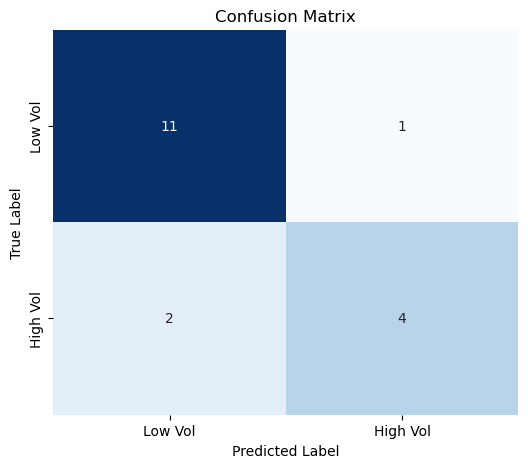

              precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.80      0.67      0.73         6

    accuracy                           0.83        18
   macro avg       0.82      0.79      0.80        18
weighted avg       0.83      0.83      0.83        18



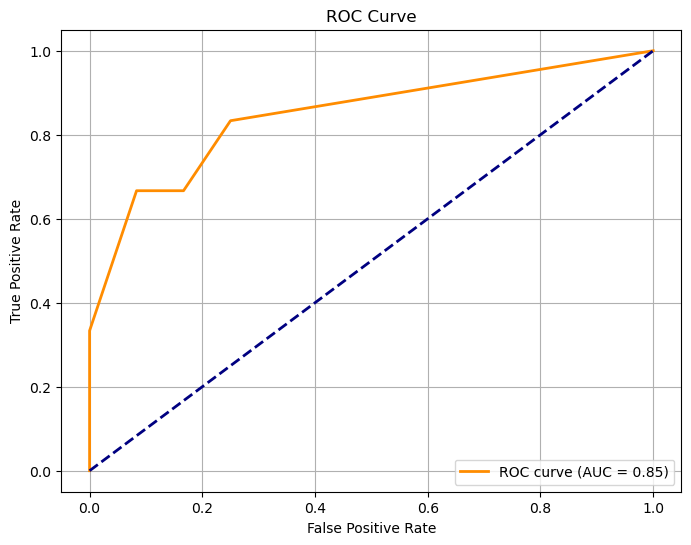

SUCCESS! Charts saved to 'Pictures/'.


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

data = pd.read_csv('Data/processed_monthly_data.csv', index_col='Date')

feature_cols = ['Volatility_Current', 'Volume_Mean', 'Price_Mean']
X = data[feature_cols]
y = data['Target_Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)
y_prob = knn.predict_proba(X_test_scaled)[:, 1]

if not os.path.exists('Pictures'):
    os.makedirs('Pictures')

print("\n--- Model Evaluation ---")
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low Vol', 'High Vol'],
            yticklabels=['Low Vol', 'High Vol'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('Pictures/confusion_matrix.png')
plt.show()

print(classification_report(y_test, y_pred, labels=[0, 1], zero_division=0))

if len(y_test.unique()) > 1:
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('Pictures/roc_curve.png')
    plt.show()
else:
    print("Not enough variety in test data for ROC Curve.")

print("SUCCESS! Charts saved to 'Pictures/'.")